In [2]:
"""
CHANGE ADDRESS DETECTION - Machine Learning Project
====================================================

BUSINESS CONTEXT:
In Bitcoin transactions, "change addresses" are created to return leftover funds.
Identifying these is crucial for:
- Tracking money flows
- Entity clustering (grouping addresses by owner)
- Risk assessment
- Blockchain investigations

This is a REAL problem that companies like Chainalysis and Podproza solve.

APPROACH:
We'll build an ML classifier to detect change addresses based on:
- Transaction patterns
- Amount characteristics  
- Timing features
- Position in transaction

Author: Cristian Garcia
Date: January 2026
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print("✅ Libraries loaded")
print("🎯 PROJECT: Change Address Detection using Machine Learning")

✅ Libraries loaded
🎯 PROJECT: Change Address Detection using Machine Learning


In [3]:
# Create synthetic dataset for change address detection
# Based on real Bitcoin transaction patterns

np.random.seed(42)

def generate_transaction_features(n_samples=1000, is_change=True):
    """
    Generate features that distinguish change addresses from recipient addresses
    
    Key patterns in change addresses:
    - Usually smaller amounts (leftover from transaction)
    - Often appear as second output in transaction
    - Round numbers less common (change is usually "odd" amount)
    - Higher probability of being spent soon after
    """
    
    if is_change:
        # Change addresses characteristics
        amounts = np.random.lognormal(mean=0.5, sigma=1.5, size=n_samples)  # Smaller amounts
        output_position = np.random.choice([1, 2], size=n_samples, p=[0.2, 0.8])  # Usually 2nd output
        is_round = np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1])  # Rarely round
        time_to_spend = np.random.exponential(scale=2, size=n_samples)  # Spent relatively soon
        
    else:
        # Regular recipient addresses characteristics  
        amounts = np.random.lognormal(mean=1.5, sigma=1.0, size=n_samples)  # Larger amounts
        output_position = np.random.choice([1, 2], size=n_samples, p=[0.7, 0.3])  # Usually 1st output
        is_round = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # More round numbers
        time_to_spend = np.random.exponential(scale=10, size=n_samples)  # Spent later or not at all
    
    return pd.DataFrame({
        'amount_btc': amounts,
        'output_position': output_position,
        'is_round_number': is_round,
        'days_until_spent': time_to_spend,
        'is_change': 1 if is_change else 0
    })

# Generate balanced dataset
change_addresses = generate_transaction_features(n_samples=500, is_change=True)
recipient_addresses = generate_transaction_features(n_samples=500, is_change=False)

# Combine
df = pd.concat([change_addresses, recipient_addresses], ignore_index=True)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Dataset created: {len(df)} transactions")
print(f"📊 Balance: {df['is_change'].sum()} change addresses, {len(df) - df['is_change'].sum()} recipient addresses")
print("\n📋 First 5 rows:")
df.head()

✅ Dataset created: 1000 transactions
📊 Balance: 500 change addresses, 500 recipient addresses

📋 First 5 rows:


,amount_btc,output_position,is_round_number,days_until_spent,is_change
0,31.153575,2,0,3.957050,0
1,41.733332,1,1,5.018202,0
2,0.740035,1,0,8.486225,0
3,2.429202,1,1,29.328748,0
4,0.305147,2,0,0.801597,1


C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:40: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:40: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:40: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND

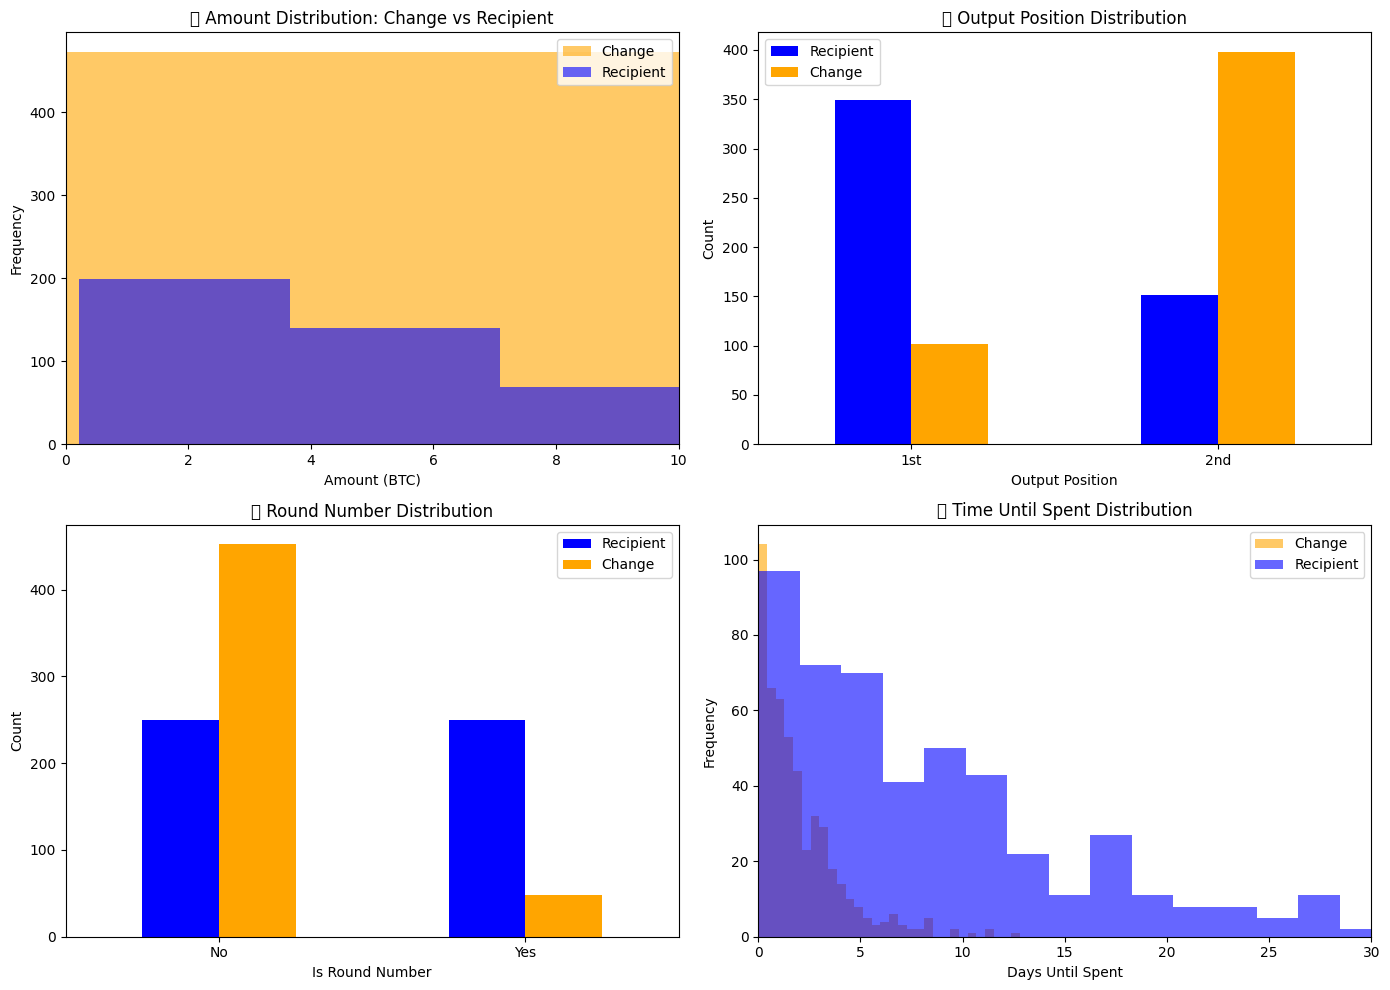

✅ Visualization complete

🔍 KEY INSIGHTS:
- Change addresses tend to have SMALLER amounts
- Change addresses are usually in POSITION 2
- Change addresses have FEWER round numbers
- Change addresses are spent SOONER


C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:87: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:87: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:87: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:87: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND

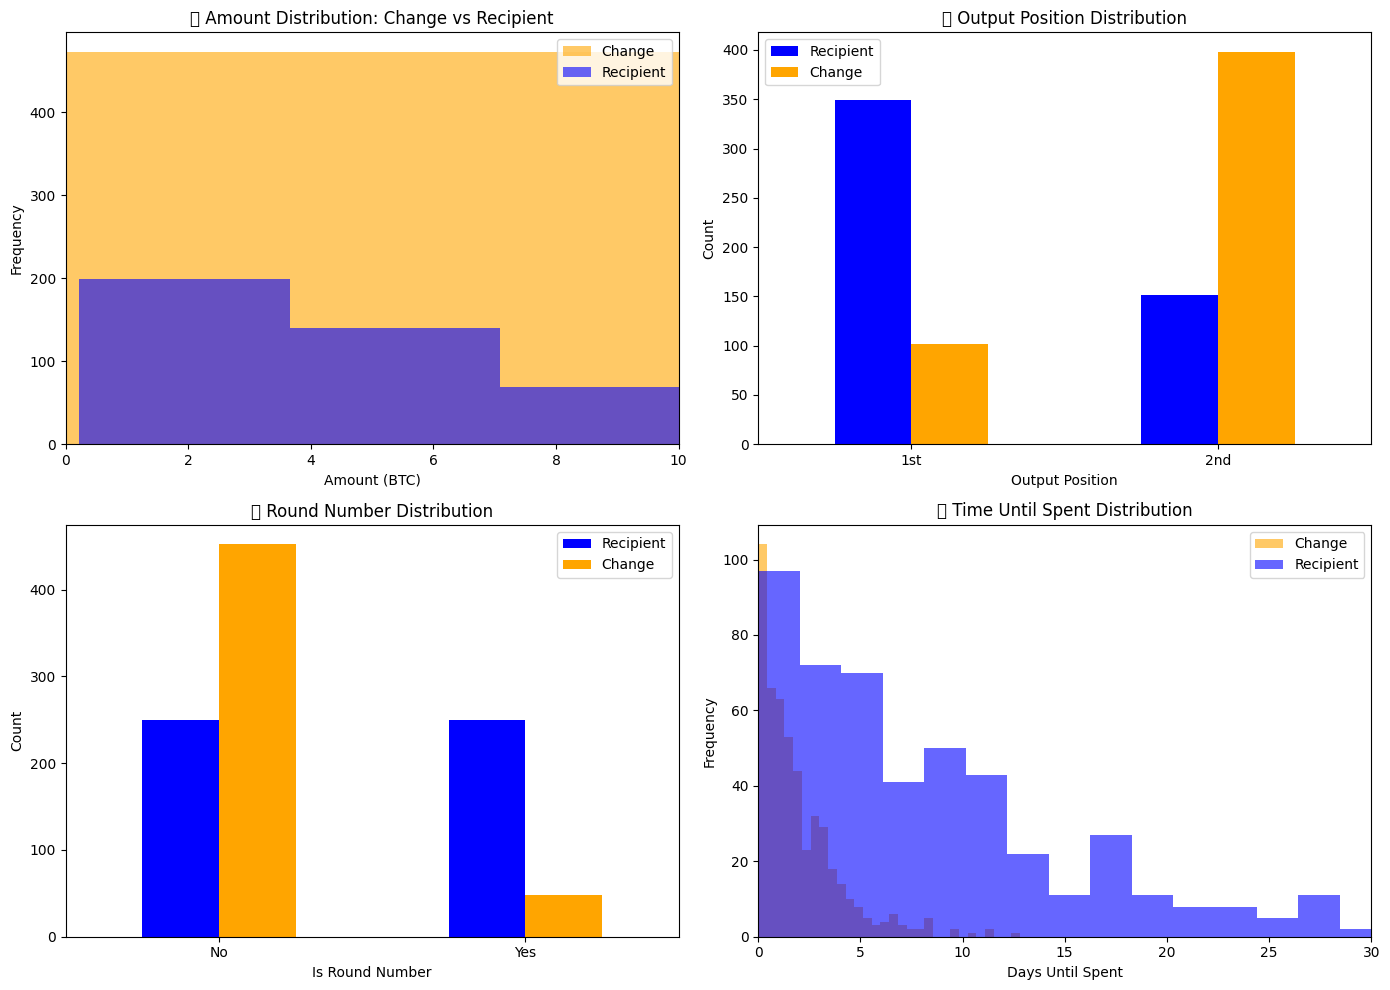

✅ Visualization complete

🔍 KEY INSIGHTS:
- Change addresses tend to have SMALLER amounts
- Change addresses are usually in POSITION 2
- Change addresses have FEWER round numbers
- Change addresses are spent SOONER


C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:134: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:134: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:134: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paran\AppData\Local\Temp\ipykernel_12300\1790155962.py:134: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\paran\anaconda3\envs\Test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{R

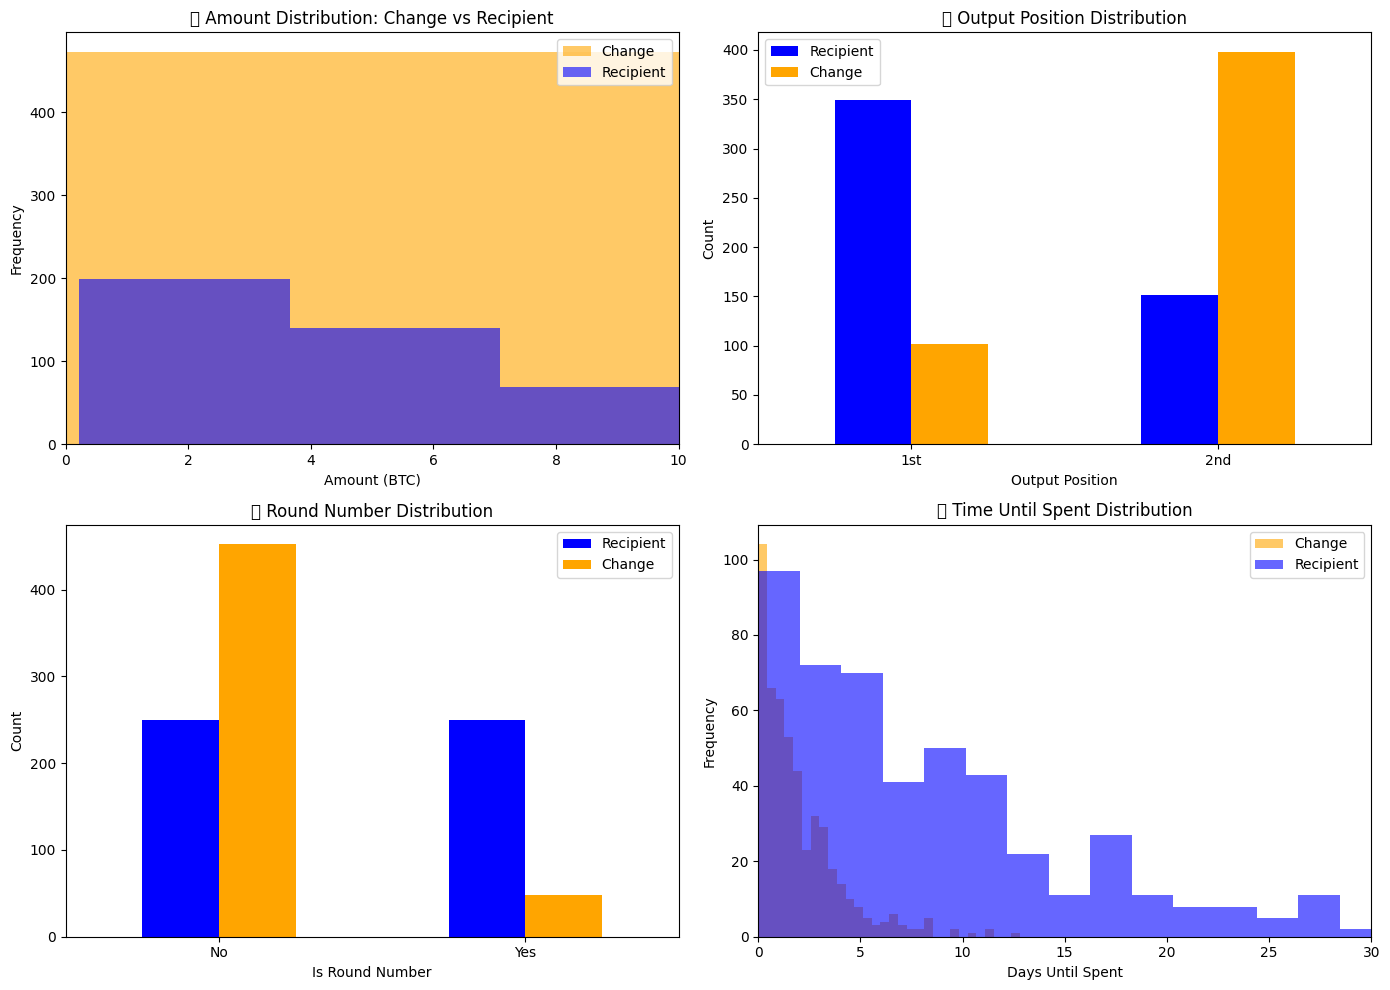

✅ Visualization complete

🔍 KEY INSIGHTS:
- Change addresses tend to have SMALLER amounts
- Change addresses are usually in POSITION 2
- Change addresses have FEWER round numbers
- Change addresses are spent SOONER


In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Amount distribution
axes[0, 0].hist(df[df['is_change']==1]['amount_btc'], bins=30, alpha=0.6, label='Change', color='orange')
axes[0, 0].hist(df[df['is_change']==0]['amount_btc'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[0, 0].set_xlabel('Amount (BTC)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('💰 Amount Distribution: Change vs Recipient')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 10)

# 2. Output position
position_data = df.groupby(['output_position', 'is_change']).size().unstack()
position_data.plot(kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_xlabel('Output Position')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('📍 Output Position Distribution')
axes[0, 1].legend(['Recipient', 'Change'])
axes[0, 1].set_xticklabels(['1st', '2nd'], rotation=0)

# 3. Round numbers
round_data = df.groupby(['is_round_number', 'is_change']).size().unstack()
round_data.plot(kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_xlabel('Is Round Number')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('🔢 Round Number Distribution')
axes[1, 0].legend(['Recipient', 'Change'])
axes[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)

# 4. Time to spend
axes[1, 1].hist(df[df['is_change']==1]['days_until_spent'], bins=30, alpha=0.6, label='Change', color='orange')
axes[1, 1].hist(df[df['is_change']==0]['days_until_spent'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[1, 1].set_xlabel('Days Until Spent')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('⏱️ Time Until Spent Distribution')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")
print("\n🔍 KEY INSIGHTS:")
print("- Change addresses tend to have SMALLER amounts")
print("- Change addresses are usually in POSITION 2")
print("- Change addresses have FEWER round numbers")
print("- Change addresses are spent SOONER")# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Amount distribution
axes[0, 0].hist(df[df['is_change']==1]['amount_btc'], bins=30, alpha=0.6, label='Change', color='orange')
axes[0, 0].hist(df[df['is_change']==0]['amount_btc'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[0, 0].set_xlabel('Amount (BTC)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('💰 Amount Distribution: Change vs Recipient')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 10)

# 2. Output position
position_data = df.groupby(['output_position', 'is_change']).size().unstack()
position_data.plot(kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_xlabel('Output Position')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('📍 Output Position Distribution')
axes[0, 1].legend(['Recipient', 'Change'])
axes[0, 1].set_xticklabels(['1st', '2nd'], rotation=0)

# 3. Round numbers
round_data = df.groupby(['is_round_number', 'is_change']).size().unstack()
round_data.plot(kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_xlabel('Is Round Number')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('🔢 Round Number Distribution')
axes[1, 0].legend(['Recipient', 'Change'])
axes[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)

# 4. Time to spend
axes[1, 1].hist(df[df['is_change']==1]['days_until_spent'], bins=30, alpha=0.6, label='Change', color='orange')
axes[1, 1].hist(df[df['is_change']==0]['days_until_spent'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[1, 1].set_xlabel('Days Until Spent')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('⏱️ Time Until Spent Distribution')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")
print("\n🔍 KEY INSIGHTS:")
print("- Change addresses tend to have SMALLER amounts")
print("- Change addresses are usually in POSITION 2")
print("- Change addresses have FEWER round numbers")
print("- Change addresses are spent SOONER")# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Amount distribution
axes[0, 0].hist(df[df['is_change']==1]['amount_btc'], bins=30, alpha=0.6, label='Change', color='orange')
axes[0, 0].hist(df[df['is_change']==0]['amount_btc'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[0, 0].set_xlabel('Amount (BTC)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('💰 Amount Distribution: Change vs Recipient')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 10)

# 2. Output position
position_data = df.groupby(['output_position', 'is_change']).size().unstack()
position_data.plot(kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_xlabel('Output Position')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('📍 Output Position Distribution')
axes[0, 1].legend(['Recipient', 'Change'])
axes[0, 1].set_xticklabels(['1st', '2nd'], rotation=0)

# 3. Round numbers
round_data = df.groupby(['is_round_number', 'is_change']).size().unstack()
round_data.plot(kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_xlabel('Is Round Number')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('🔢 Round Number Distribution')
axes[1, 0].legend(['Recipient', 'Change'])
axes[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)

# 4. Time to spend
axes[1, 1].hist(df[df['is_change']==1]['days_until_spent'], bins=30, alpha=0.6, label='Change', color='orange')
axes[1, 1].hist(df[df['is_change']==0]['days_until_spent'], bins=30, alpha=0.6, label='Recipient', color='blue')
axes[1, 1].set_xlabel('Days Until Spent')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('⏱️ Time Until Spent Distribution')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")
print("\n🔍 KEY INSIGHTS:")
print("- Change addresses tend to have SMALLER amounts")
print("- Change addresses are usually in POSITION 2")
print("- Change addresses have FEWER round numbers")
print("- Change addresses are spent SOONER")

In [5]:
# Prepare data for Machine Learning
print("🔧 PREPARING DATA FOR ML MODEL")

# Features (X) = inputs for the model
X = df[['amount_btc', 'output_position', 'is_round_number', 'days_until_spent']]

# Target (y) = what we want to predict
y = df['is_change']

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Training set: {len(X_train)} transactions")
print(f"✅ Testing set: {len(X_test)} transactions")
print(f"\n📊 Training set balance:")
print(f"   - Change addresses: {y_train.sum()}")
print(f"   - Recipient addresses: {len(y_train) - y_train.sum()}")

🔧 PREPARING DATA FOR ML MODEL
✅ Training set: 800 transactions
✅ Testing set: 200 transactions

📊 Training set balance:
   - Change addresses: 400
   - Recipient addresses: 400


In [6]:
# Train Random Forest Classifier
print("🤖 TRAINING MACHINE LEARNING MODEL")
print("Algorithm: Random Forest Classifier")
print("-" * 50)

# Create the model
model = RandomForestClassifier(
    n_estimators=100,      # 100 decision trees
    random_state=42,       # Reproducibility
    max_depth=10,          # Maximum tree depth
    min_samples_split=5    # Minimum samples to split
)

# Train the model
model.fit(X_train, y_train)

print("✅ Model trained successfully!")
print(f"\n📊 Model details:")
print(f"   - Number of trees: {model.n_estimators}")
print(f"   - Features used: {list(X_train.columns)}")

🤖 TRAINING MACHINE LEARNING MODEL
Algorithm: Random Forest Classifier
--------------------------------------------------
✅ Model trained successfully!

📊 Model details:
   - Number of trees: 100
   - Features used: ['amount_btc', 'output_position', 'is_round_number', 'days_until_spent']


In [7]:
# Evaluate the model on TEST data (data it has NEVER seen)
print("📊 EVALUATING MODEL PERFORMANCE")
print("=" * 50)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 ACCURACY: {accuracy:.2%}")
print(f"   (The model correctly classified {accuracy:.2%} of transactions)")

# Detailed classification report
print("\n📋 DETAILED PERFORMANCE:")
print(classification_report(y_test, y_pred, target_names=['Recipient', 'Change']))

# Confusion Matrix
print("\n🔢 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\nExplanation:")
print(f"   - True Negatives (Recipient correctly identified): {cm[0,0]}")
print(f"   - False Positives (Recipient predicted as Change): {cm[0,1]}")
print(f"   - False Negatives (Change predicted as Recipient): {cm[1,0]}")
print(f"   - True Positives (Change correctly identified): {cm[1,1]}")

📊 EVALUATING MODEL PERFORMANCE

🎯 ACCURACY: 84.50%
   (The model correctly classified 84.50% of transactions)

📋 DETAILED PERFORMANCE:
              precision    recall  f1-score   support

   Recipient       0.82      0.88      0.85       100
      Change       0.87      0.81      0.84       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200


🔢 CONFUSION MATRIX:
[[88 12]
 [19 81]]

Explanation:
   - True Negatives (Recipient correctly identified): 88
   - False Positives (Recipient predicted as Change): 12
   - False Negatives (Change predicted as Recipient): 19
   - True Positives (Change correctly identified): 81
